In [1]:
print("ok")

ok


In [2]:
from langchain_openai import ChatOpenAI

In [3]:
from dotenv import load_dotenv

In [4]:
load_dotenv()

True

In [5]:
import os
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")

In [6]:
os.environ["OPENAI_API_KEY"]=OPENAI_API_KEY

In [7]:
openai_model=ChatOpenAI(model="gpt-4o")

In [8]:
openai_model.invoke("hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_92f14e8683', 'finish_reason': 'stop', 'logprobs': None}, id='run-89dec87b-7177-4fd6-bc1a-14a5790ee9d9-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [9]:
openai_model.invoke("hi").content

'Hello! How can I assist you today?'

In [10]:
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

In [15]:
state={}

In [16]:
state["messages"]=[]

In [17]:
state

{'messages': []}

In [18]:
state["messages"].append("hi")

In [19]:
state

{'messages': ['hi']}

In [20]:
state["messages"].append("how are you?")

In [21]:
state

{'messages': ['hi', 'how are you?']}

In [22]:
state["messages"].append("what going on?")

In [ ]:
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [23]:
state

{'messages': ['hi', 'how are you?', 'what going on?']}

In [24]:
state["messages"][0]

'hi'

In [25]:
state["messages"][-1]

'what going on?'

In [ ]:
## this state is a dict which containing the message as list and inside the list there could be n numbvers of messages

## this state will be flowing across all the nodes(function) in langgraph

In [26]:
def call_model(state:MessagesState):
    question=state["messages"]
    response=openai_model.invoke(question)
    return {"messages":[response]}

In [27]:
workflow=StateGraph(MessagesState)

In [28]:
workflow.add_node("chatbot",call_model)

In [30]:
workflow.add_edge(START,"chatbot")

In [32]:
workflow.add_edge("chatbot",END)

In [34]:
app=workflow.compile()

In [39]:
from IPython.display import Image,display

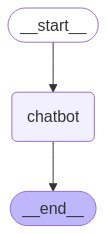

In [36]:
display(Image(app.get_graph().draw_mermaid_png()))

In [37]:
input={"messages":["hi my name is sunny"]}

In [39]:
response=app.invoke(input)

In [40]:
response["messages"][-1].content

'Hi Sunny! How can I assist you today?'

In [41]:
for output in app.stream(input):
    for key,value in output.items():
        print(f"Output from {key} Node")
        print("_______")
        print(value)
        print("\n")

Output from chatbot Node
_______
{'messages': [AIMessage(content='Hello, Sunny! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 12, 'total_tokens': 24, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_92f14e8683', 'finish_reason': 'stop', 'logprobs': None}, id='run-903df924-4611-4362-a679-75ec97dc96e3-0', usage_metadata={'input_tokens': 12, 'output_tokens': 12, 'total_tokens': 24, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}




In [11]:
@tool
def search(query:str):
    """this is a tool for weather checking"""
    if "india" in query.lower() or "delhi" in query.lower():
        return "the weather is hotty with some foggy"
    return "weather is cloudy with some darkness"

In [12]:
search.invoke("what is a weather in japan?")

'weather is cloudy with some darkness'

In [13]:
search.invoke("what is a weather in delhi?")

'the weather is hotty with some foggy'

In [14]:
tools=[search]

In [15]:
llm_with_tool=openai_model.bind_tools(tools)

In [16]:
response=llm_with_tool.invoke("hi")

In [17]:
response.content

'Hello! How can I assist you today?'

In [18]:
response.tool_calls

[]

In [19]:
result=llm_with_tool.invoke("what is a weather in europ?")

In [20]:
result.content

''

In [21]:
result.tool_calls

[{'name': 'search',
  'args': {'query': 'current weather in Europe'},
  'id': 'call_tol5hOy9LHURFgg9ZAxusqT9',
  'type': 'tool_call'}]

In [23]:
def call_model(state:MessagesState):
    question=state["messages"]
    response=llm_with_tool.invoke(question)
    return {"messages":[response]}

In [24]:
input={'messages': ['hi my name is sunny']}

In [25]:
response=call_model(input)

In [26]:
message=response["messages"]

In [27]:
last_message=message[-1]

In [28]:
last_message.content

'Hello Sunny! How can I assist you today?'

In [29]:
last_message.tool_calls

[]

In [30]:
input={'messages': ['what is a weather in mumbai?']}

In [42]:
def router_function(state: MessagesState):
    message=state["messages"]
    last_message=message[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [43]:
tools

[StructuredTool(name='search', description='this is a tool for weather checking', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x000001A1C4A789D0>)]

In [44]:
tool_node=ToolNode(tools)

In [45]:
workflow=StateGraph(MessagesState)

In [46]:
workflow.add_node("assistant",call_model)
workflow.add_node("myweathertool",tool_node)

In [47]:
workflow.add_edge(START, "assistant")

workflow.add_conditional_edges("assistant",
                               router_function,
                               {"tools": "myweathertool", END: END})

app = workflow.compile()

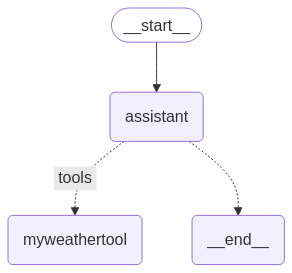

In [48]:
display(Image(app.get_graph().draw_mermaid_png()))

In [50]:
app.invoke({"messages": ["how are you?"]})

{'messages': [HumanMessage(content='how are you?', additional_kwargs={}, response_metadata={}, id='35304953-def9-411a-af33-c13da0c59f4c'),
  AIMessage(content="I'm just a computer program, but I'm here and ready to assist you with any questions or tasks you have! How can I help you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 48, 'total_tokens': 79, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_92f14e8683', 'finish_reason': 'stop', 'logprobs': None}, id='run-3157f5ac-6c9a-4994-8049-5df4c46f80bc-0', usage_metadata={'input_tokens': 48, 'output_tokens': 31, 'total_tokens': 79, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [49]:
app.invoke({"messages": ["what is a weather in delhi?"]})

{'messages': [HumanMessage(content='what is a weather in delhi?', additional_kwargs={}, response_metadata={}, id='ab97e960-4f75-4bc2-b33d-2e71af5e9636'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yGUyksdfre0oMUxMjgvXqlDE', 'function': {'arguments': '{"query":"current weather in Delhi"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 52, 'total_tokens': 69, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_92f14e8683', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-285abba1-b433-40a6-a6c4-c7cab0b01878-0', tool_calls=[{'name': 'search', 'args': {'query': 'current weather in Delhi'}, 'id': 'call_yGUyksdfre0oMUxMjgvXqlDE', 'type': 'tool_call'}], usa

In [51]:
workflow.add_edge("myweathertool","assistant")

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [52]:
app = workflow.compile()

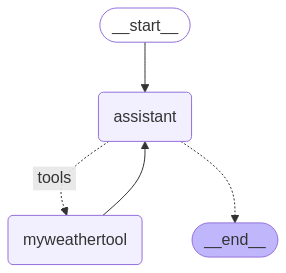

In [53]:
display(Image(app.get_graph().draw_mermaid_png()))

In [54]:
app.invoke({"messages": ["what is a weather in delhi?"]})

{'messages': [HumanMessage(content='what is a weather in delhi?', additional_kwargs={}, response_metadata={}, id='a61d43f6-a7ab-411e-b5f2-d3036f07ddf1'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Pn87PZzbsUUYACk0VKthO2P3', 'function': {'arguments': '{"query":"weather in Delhi"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 52, 'total_tokens': 68, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_92f14e8683', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a19fc966-7252-4855-9a4d-dba03fa17b96-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in Delhi'}, 'id': 'call_Pn87PZzbsUUYACk0VKthO2P3', 'type': 'tool_call'}], usage_metadata={'in

In [55]:
for output in app.stream({"messages": ["what is the weather in delhi"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from assistant
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_IJu4cbfI4ndMBtAfhktxkHnI', 'function': {'arguments': '{"query":"Delhi weather"}', 'name': 'search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 51, 'total_tokens': 66, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_92f14e8683', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fdd38279-e818-4183-a107-043832941dae-0', tool_calls=[{'name': 'search', 'args': {'query': 'Delhi weather'}, 'id': 'call_IJu4cbfI4ndMBtAfhktxkHnI', 'type': 'tool_call'}], usage_metadata={'input_tokens': 51, 'output_tokens': 15, 'total_tokens': 66, 'input_token_details': {'audio': 0, 'cache_read': 0}

In [ ]:
@tool
def multiply(a:int,b:int)->int:
    """multiply a and b"""
    return a*b

In [58]:
@tool
def add(a:int,b:int)->int:
    """adding two numbers a and b"""
    return a+b

In [59]:
@tool
def divide(a:int,b:int)->int:
    """dividing two numbers a and b"""
    return a/b

In [61]:
@tool
def subtract(a:int,b:int)->int:
    """subtracting two numbers a and b """
    return a-b

In [78]:
from langchain_community.tools import DuckDuckGoSearchRun


In [79]:
duckduckgo_search=DuckDuckGoSearchRun()

In [80]:
duckduckgo_search.invoke("who is a current prime minister of USA??")

"This is a list of current heads of state and heads of government. In some cases, ... Prime Minister - Keir Starmer United States: President - Donald Trump ... Prime Minister - Vacant: Sui generis entities. Entity Head of entity Head of government The White House, official residence of the president of the United States. The president of the United States is the head of state and head of government of the United States, [1] indirectly elected to a four-year term via the Electoral College. [2] Under the U.S. Constitution, the officeholder leads the executive branch of the federal government and is the commander-in-chief of the United ... The absence of a prime minister in the United States is a result of deliberate choices made by the country's Founding Fathers, who designed a political system that contrasts sharply with parliamentary systems. This article explores the reasons why the U.S. doesn't have a prime minister, focusing on the country's historical context, the ... Joe Biden (bo

In [81]:
tools=[multiply, add, divide, subtract, duckduckgo_search]

In [82]:
llm_with_tools=openai_model.bind_tools(tools)

In [83]:
llm_with_tools

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000001A1C4897490>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001A1C48C1DE0>, root_client=<openai.OpenAI object at 0x000001A1C47F8CD0>, root_async_client=<openai.AsyncOpenAI object at 0x000001A1C48974F0>, model_name='gpt-4o', model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'multiply', 'description': 'multiply a and b', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'add', 'description': 'adding two numbers a and b', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'divide', 'description': 'dividing two numbers a and b', 

In [84]:
llm_with_tools.invoke("hi").tool_calls

[]

In [85]:
llm_with_tools.invoke("can you add these two number 5 and 40?").tool_calls

[{'name': 'add',
  'args': {'a': 5, 'b': 40},
  'id': 'call_0v1Qi6xpFx9xyOrU7lKTxdAJ',
  'type': 'tool_call'}]

In [86]:
llm_with_tools.invoke("can you multiply these two number 5 and 40?").tool_calls

[{'name': 'multiply',
  'args': {'a': 5, 'b': 40},
  'id': 'call_0t4cAMW9twoYZwnssQpdgUlm',
  'type': 'tool_call'}]

In [87]:
llm_with_tools.invoke("can you divide these two number 5 and 40?").tool_calls

[{'name': 'divide',
  'args': {'a': 5, 'b': 40},
  'id': 'call_ZB3IucS7KkgxpRpDie2HsXC8',
  'type': 'tool_call'}]

In [88]:
llm_with_tools.invoke("what is a current gdp of india with current affaires").tool_calls

[{'name': 'duckduckgo_search',
  'args': {'query': 'current GDP of India 2023'},
  'id': 'call_3kC1SSdjS3b84VTvw4Wy8dEs',
  'type': 'tool_call'}]

In [91]:
from langchain_core.messages import HumanMessage, SystemMessage

In [92]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")
     

In [103]:
def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg]+state["messages"])]}

In [104]:
builder=StateGraph(MessagesState)

In [105]:
builder.add_node("assistant",assistant)

In [106]:
builder.add_node("tools",ToolNode(tools))

In [107]:
builder.add_edge(START,"assistant")

In [108]:

from langgraph.prebuilt import tools_condition

In [109]:
builder.add_conditional_edges(
    "assistant",
    tools_condition
)

In [110]:
react_app=builder.compile()

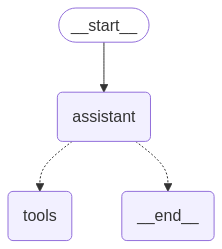

In [111]:
display(Image(react_app.get_graph().draw_mermaid_png()))

In [112]:
builder.add_edge("tools","assistant")

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [113]:
react_app=builder.compile()

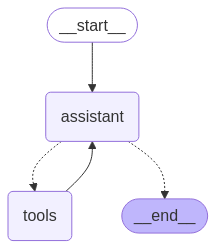

In [114]:
display(Image(react_app.get_graph().draw_mermaid_png()))

In [115]:
message=[HumanMessage(content="what is twice of narendra modi's current age?")]

## this below detail is called a agentic flow
# first it will come to assistant
# then it will search narendra modi age
# then it will come to again assistant
# then it wil call the multiply tool for getting twice of age
# then again it will come to assistant 
# then it will generate a final answer

# REACT->> Reasoning+actions

# Thinking, action, observation, thiniking,action, observation---> if everything is going to be full fill
# then generating a final ans

In [117]:
response=react_app.invoke({"messages":message})

In [118]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is twice of narendra modi's current age?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_No6zjTboZqk3p2UwzO0Lfy5t)
 Call ID: call_No6zjTboZqk3p2UwzO0Lfy5t
  Args:
    query: Narendra Modi age 2023
================================= Tool Message =================================
Name: duckduckgo_search

Learn about the life and achievements of Narendra Modi, the current Prime Minister of India, who was born on September 17, 1950, in Gujarat. Find out his full name, education, political journey, and constituency. 2023: PM Narendra Modi announced the PM Vishwakarma Yojana to enhance the skilling of craftsmen and artisans in the country. Two key infrastructure projects - India International Convention and ... List of all Prime Ministers of India till 2025: Narendra Modi is the current and 14th Prime Minister of India who assumed office

In [119]:
messages=[HumanMessage(content="hi hello how are you?")]

In [120]:
response=react_app.invoke({"messages":messages})

In [121]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

hi hello how are you?
================================== Ai Message ==================================

Hello! I'm here to assist you. How can I help you today?


1. humanmessage
2. ai mesage:toolcall
3. duckcuk
4. ai assistant
5. sustract
6. ai
7. final answer

In [123]:
messages=[HumanMessage(content="what is current gdp of china and india can you give me difference between them?")]

In [124]:
response=react_app.invoke({"messages":messages})

In [125]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is current gdp of china and india can you give me difference between them?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (call_0ONjcU39PBQslxPd6PCRbmjW)
 Call ID: call_0ONjcU39PBQslxPd6PCRbmjW
  Args:
    query: current GDP of China 2023
  duckduckgo_search (call_bBNSA8mOcuWhxnD9FtYq1bkp)
 Call ID: call_bBNSA8mOcuWhxnD9FtYq1bkp
  Args:
    query: current GDP of India 2023
================================= Tool Message =================================
Name: duckduckgo_search

China revised upwards on Thursday the size of its economy by 2.7%, but said the change would have little impact on growth this year, as policymakers pledged more stimulus to spur expansion in 2025. China's gross domestic product (GDP) in 2023 was revised to 129.4 trillion yuan ($17.73 trillion), up 3.37 trillion yuan, or 2.7 percent, from the preliminary figure, 

As of 2023, China's GDP is approximately $17.73 trillion, while India's GDP is about $3.9 trillion. The difference in their GDPs is approximately $13.83 trillion, with China's economy being larger than India's by this amount.

In [ ]:
project:rag,agent,deployment,modularcoding,ci/cd,git

multiagentic collrabtive agent and supoervisor agent



Reaserch and analsysis react agent: assisgnment
1. llm assistant
2. take a realtime weather api to check the real time weather detail
3. take a realtime api for checking realtime cricket score
4. take a tool for analysis the generated data(REPL)python code
5. create a report based on the generated data
memory
human in loop
multiagentic flow


from next week onwards will implemnt the project